In [502]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [466]:
# Read Data
transactions = pd.read_csv("Data/transactions.csv")
test = pd.read_csv("Data/test.csv")
stores = pd.read_csv("Data/stores.csv")
holidays = pd.read_csv("Data/holidays_events.csv")
print("data has been loaded")
test = test.groupby(['date', 'store_nbr']).sum().reset_index()[["date","store_nbr"]]

data has been loaded


In [467]:
def merge_and_format(df, stores, holidays):
    # Format as datetime
    df['date'] = pd.to_datetime(df['date'])
    # Merge with the stores data
    df_merged = pd.merge(df, stores, on='store_nbr')

    # Prep the holidays data
    holidays_column_names = ['date', 'holiday_type', 'locale', 'locale_name', 'holiday_name', 'transferred']
    holidays.columns = holidays_column_names
    # select the holidays that are important
    important_holidays = [
        'Traslado Batalla de Pichincha', 'Viernes Santo', 'Carnaval',"Navidad+1", "Navidad-1", 
        "Navidad-2", "Fundacion de Quito", "Traslado Primer dia del ano", "Puente Primer dia del ano", "Primer dia del ano",
        "Primer dia del ano-1", "Dia de Difuntos", "Traslado Primer Grito de Independencia", "Puente Dia de Difuntos", 
        "Independencia de Cuenca"]
    # Filter the data
    holidays = holidays[holidays['holiday_name'].isin(important_holidays)]
    holidays = holidays[['date', 'holiday_name']]
    holidays['date'] = pd.to_datetime(holidays['date'])
    # display(holidays.head())
    # Merge with the holidays
    df_merged = df_merged.merge(holidays, on='date', how="left")
    df_merged['holiday_name'] = df_merged['holiday_name'].fillna('no_holiday')
    return df_merged

In [470]:
def create_features(df, train=True): 
    # display(df.head())
    df['date'] = pd.to_datetime(df['date'])
    # Time Features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["weekday"] = df["date"].dt.weekday
    df["week_of_year"] = df["date"].dt.isocalendar().week
    df["day_of_year"] = df["date"].dt.dayofyear
    df["quarter"] = df["date"].dt.quarter
    df['day_cat'] = df['date'].dt.day_name()
    df["month_cat"] = df["date"].dt.month_name()
    
    # Categorical Features
    df["store_nbr"] = df["store_nbr"].astype(str)
    df['cluster'] = df['cluster'].astype(str)
    df['is_holiday'] = np.where(df['holiday_name'] == 'no_holiday', "not_holiday", "holiday")

    # Store-Holiday Interactions
    df['store_holiday_interaction'] = df['store_nbr'] + "_" + df['is_holiday']
    df['store_day_interaction'] = df['store_nbr'] + "_" + df['day_cat']
    df['store_month_interaction'] = df['store_nbr'] + "_" + df['month_cat']
    df['type_day_interaction'] = df['type'] + "_" + df['day_cat']
    df['holiday_day_interaction'] = df['holiday_name'] + "_" + df['day_cat']
    df["dec"] = np.where(df["month_cat"] == "December", 'dec', 'not_dec')
    df['dec_day_interaction'] = df['day_cat'] + "_" + df['dec']
    # If the test data is passed through here, we need to include some of the training data to create the lags
    if train == False:
        transactions_filter = transactions.loc[transactions['date'] >= '2017-07-17']
        df = pd.concat([transactions_filter, df],axis =0)
        df = df.reset_index(drop = True)
        df["store_nbr"] = df["store_nbr"].astype(str)
        df = df.sort_values(['store_nbr', 'date'])
    else:
    # Rolling features for the training data
        window_size = 7
        df['transactions_rolling_avg'] = df.groupby('store_nbr')['transactions'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    # Lagged features 
    df["trans_lag"] = df.groupby('store_nbr')['transactions'].shift(1)
    df["trans_lag_2"] = df.groupby('store_nbr')['transactions'].shift(2)
    df["trans_lag_3"] = df.groupby('store_nbr')['transactions'].shift(3)
    df["trans_lag_7"] = df.groupby('store_nbr')['transactions'].shift(7)
    df["trans_lag_14"] = df.groupby('store_nbr')['transactions'].shift(14)
    df["trans_lag_30"] = df.groupby('store_nbr')['transactions'].shift(30)
    df = df.dropna(subset=['trans_lag_30'])  # Remove rows with missing lags
    return df

In [471]:
train = merge_and_format(transactions, stores, holidays)
train = create_features(train, train=True)
train.head(2)

,date,store_nbr,transactions,city,state,type,cluster,holiday_name,year,month,...,holiday_day_interaction,dec,dec_day_interaction,transactions_rolling_avg,trans_lag,trans_lag_2,trans_lag_3,trans_lag_7,trans_lag_14,trans_lag_30
1356,2013-01-31,25,714,Salinas,Santa Elena,D,1,no_holiday,2013,1,...,no_holiday_Thursday,not_dec,Thursday_not_dec,925.857143,868.0,664.0,714.0,691.0,640.0,770.0
1381,2013-02-01,1,1806,Quito,Pichincha,D,13,no_holiday,2013,2,...,no_holiday_Friday,not_dec,Friday_not_dec,1533.857143,1707.0,1877.0,1772.0,1770.0,1745.0,2111.0


In [472]:
test = merge_and_format(test, stores, holidays)
test = create_features(test, train=False)
test.head(2)

,date,store_nbr,transactions,city,state,type,cluster,holiday_name,year,month,...,type_day_interaction,holiday_day_interaction,dec,dec_day_interaction,trans_lag,trans_lag_2,trans_lag_3,trans_lag_7,trans_lag_14,trans_lag_30
1620,2017-08-16,1,NaN,Quito,Pichincha,D,13,no_holiday,2017.0,8.0,...,D_Wednesday,no_holiday_Wednesday,not_dec,Wednesday_not_dec,1693.0,1733.0,416.0,1766.0,1892.0,1739.0
1674,2017-08-17,1,NaN,Quito,Pichincha,D,13,no_holiday,2017.0,8.0,...,D_Thursday,no_holiday_Thursday,not_dec,Thursday_not_dec,NaN,1693.0,1733.0,1764.0,1726.0,1733.0


In [473]:
# Identify feature types
num_features = ["trans_lag", "trans_lag_2", "trans_lag_3", "trans_lag_7","trans_lag_14", "trans_lag_30"]
cat_features = ["store_day_interaction", "store_holiday_interaction", "type_day_interaction", "holiday_name", "dec_day_interaction"]

# Define transformations
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), 
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

ridge_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))
])

# # Prepare training data
# train = merge_data(transactions, stores, holidays)
# train = create_features(train, train=True)

# # Prepare test data
# test = merge_data(test, stores, holidays)
# test = create_features(test, train=False)  # No transactions column

X_train = train[num_features + cat_features]
y_train = train["transactions"]

# Train the model
ridge_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['trans_lag', 'trans_lag_2',
                                                   'trans_lag_3', 'trans_lag_7',
                                                   'trans_lag_14',
                                                   'trans_lag_30']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['store_day_interaction',
                                                   'store_holiday_interaction',
                                                   'type_day_interaction',
                                                   'holiday_name',
                                                   'dec_day_interaction'])])),
                ('regressor', Ridge())])

In [482]:
# Define the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Initialize a list to store errors
mse_scores = []

# Time Series Cross Validation
for train_index, val_index in tscv.split(train):
    # Split data into training and validation
    X_train, X_val = train.iloc[train_index][num_features + cat_features], train.iloc[val_index][num_features + cat_features]
    y_train, y_val = train.iloc[train_index]['transactions'], train.iloc[val_index]['transactions']

    # Train the Ridge regression model
    ridge_model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = ridge_model.predict(X_val)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)

# Print the cross-validation MSE scores
print(f"MSE scores across folds: {mse_scores}")
print(f"Average MSE: {np.mean(mse_scores)}")

MSE scores across folds: [43962.74340097587, 31447.872990029817, 32958.60612340422, 19724.94038901359, 32145.17005968674]
Average MSE: 32047.86659262205


In [496]:
resid = train.iloc[val_index][['date', 'store_nbr', 'state', 'city','type','day_cat', 'transactions']].reset_index(drop = True)
resid['y_pred'] = y_pred
resid['residuals'] = resid['transactions'] - resid['y_pred']
resid.head()

,date,store_nbr,state,city,type,day_cat,transactions,y_pred,residuals
0,2016-12-01,12,Cotopaxi,Latacunga,C,Thursday,1183,1299.810641,-116.810641
1,2016-12-01,13,Cotopaxi,Latacunga,C,Thursday,845,927.217715,-82.217715
2,2016-12-01,14,Chimborazo,Riobamba,C,Thursday,1298,1387.487244,-89.487244
3,2016-12-01,15,Imbabura,Ibarra,C,Thursday,1419,1404.409623,14.590377
4,2016-12-01,16,Santo Domingo de los Tsachilas,Santo Domingo,C,Thursday,656,809.615158,-153.615158


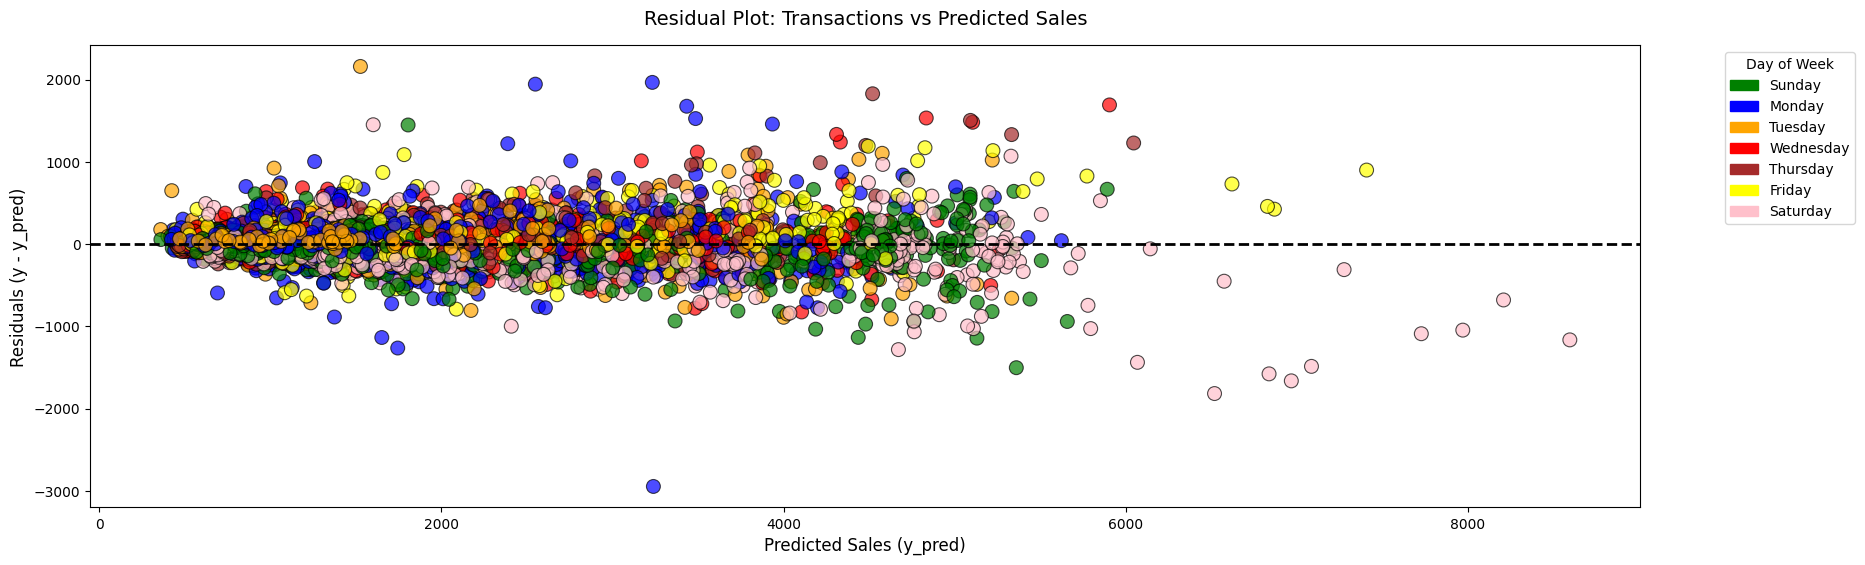

In [501]:
# Define color mapping for days
day_colors = {
    'Sunday': 'green', 'Monday': 'blue', 'Tuesday': 'orange',
    'Wednesday': 'red', 'Thursday': 'brown', 'Friday': 'yellow', 'Saturday': 'pink'
}

# Create the plot
plt.figure(figsize=(20, 6))

# Seaborn scatter plot with categorical coloring
sns.scatterplot(data=resid, x='y_pred', y='residuals', hue='day_cat', 
                palette=day_colors, alpha=0.7, edgecolor='k', s=100)

# Add a horizontal reference line at 0
plt.axhline(0, color='black', lw=2, linestyle='--')

# Labels and title
plt.title('Residual Plot: Transactions vs Predicted Sales', fontsize=14, pad=15)
plt.xlabel('Predicted Sales (y_pred)', fontsize=12)
plt.ylabel('Residuals (y - y_pred)', fontsize=12)

# Custom legend using Matplotlib patches
handles = [mpatches.Patch(color=color, label=day) for day, color in day_colors.items()]
plt.legend(handles=handles, title="Day of Week", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


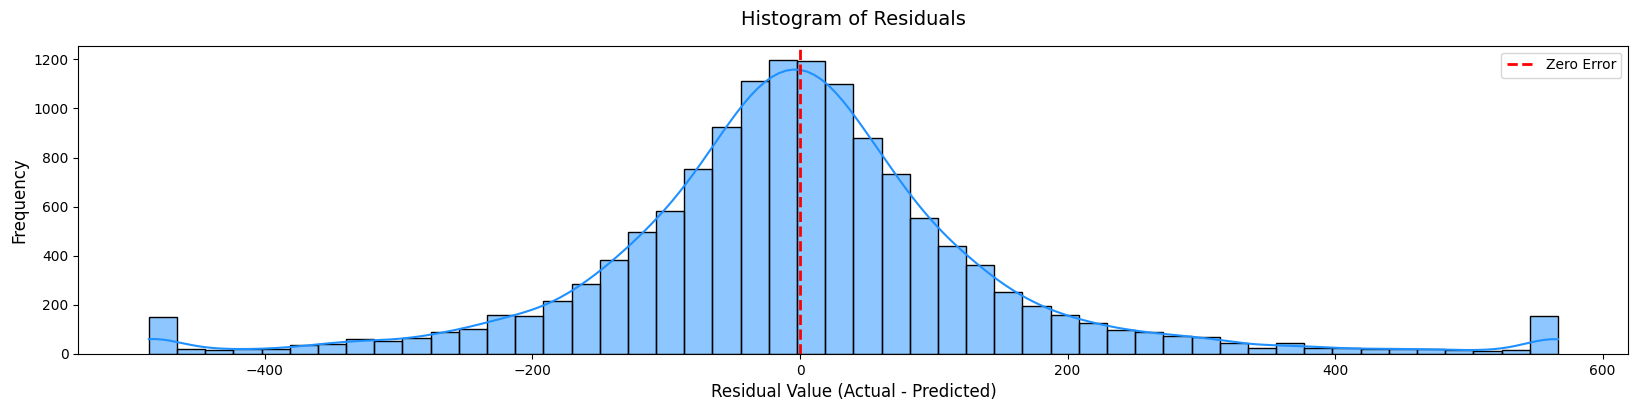

In [505]:
resid['residuals'] = resid['residuals'].clip(lower=resid['residuals'].quantile(0.01),
                                              upper=resid['residuals'].quantile(0.99))

# Set figure size
plt.figure(figsize=(20, 4))

# Seaborn histogram with KDE (Kernel Density Estimate) for smooth distribution
sns.histplot(resid['residuals'], bins=50, kde=True, color='dodgerblue', edgecolor='black')

# Add a vertical reference line at 0 (no error)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label="Zero Error")

# Labels and title
plt.title("Histogram of Residuals", fontsize=14, pad=15)
plt.xlabel("Residual Value (Actual - Predicted)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show legend
plt.legend()

# Show the plot
plt.show()

In [506]:
# Baseline prediction: Use the mean transaction value for each store
baseline_pred = train.groupby("store_nbr")["transactions"].transform("mean")

# Compute baseline MSE
baseline_mse = mean_squared_error(train["transactions"], baseline_pred)

# Compute Ridge Model MSE
model_mse = mean_squared_error(y_val, y_pred)

print(f"Baseline MSE: {baseline_mse}")
print(f"Model MSE: {model_mse}")


Baseline MSE: 128576.40499446087
Model MSE: 32145.17005968674


In [507]:
# Retrain model on full training data
ridge_model.fit(train[num_features + cat_features], train["transactions"])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['trans_lag', 'trans_lag_2',
                                                   'trans_lag_3', 'trans_lag_7',
                                                   'trans_lag_14',
                                                   'trans_lag_30']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['store_day_interaction',
                                                   'store_holiday_interaction',
                                                   'type_day_interaction',
                                                   'holiday_name',
                                                   'dec_day_interaction'])])),
                ('regressor', Ridge())])

In [508]:
# Sort test data to ensure predictions happen sequentially
test = test.sort_values(['date', 'store_nbr']).reset_index(drop=True)

# Get the unique test dates in order
test_dates = sorted(test['date'].unique())

# Iterate over each test date in order
for date in test_dates:
    for store in test['store_nbr'].unique():
        # Select the current row in the test set
        row_idx = (test['date'] == date) & (test['store_nbr'] == store)

        # Extract past transaction data for this store (previous days)
        past_data = test[(test['store_nbr'] == store) & (test['date'] < date)]

        if not past_data.empty:
            # Use the most recent transaction as the last known value
            last_transaction = past_data['transactions'].iloc[-1]
            rolling_avg = past_data['transactions'].rolling(7, min_periods=1).mean().iloc[-1]
        else:
            last_transaction, rolling_avg = np.nan, np.nan  # Handle missing cases

        # Update lagged features for this row
        test.loc[row_idx, 'trans_lag'] = last_transaction
        test.loc[row_idx, 'transactions_rolling_avg'] = rolling_avg

        # Prepare features for the prediction
        X_test = test.loc[row_idx, num_features + cat_features]

        # Predict transactions using the trained Ridge model
        predicted_value = ridge_model.predict(X_test)

        # Store the predicted transaction in the test set
        test.loc[row_idx, 'transactions'] = predicted_value


In [510]:
test[['date', 'store_nbr', 'transactions']].to_csv("transaction_pred.csv")

,date,store_nbr,transactions
0,2017-08-16,1,1664.685809
1,2017-08-16,10,1075.418560
2,2017-08-16,11,1672.251130
3,2017-08-16,12,1260.773007
4,2017-08-16,13,1077.646508
...,...,...,...
859,2017-08-31,54,958.961773
860,2017-08-31,6,1404.713579
861,2017-08-31,7,1566.163601
862,2017-08-31,8,2016.571624


In [479]:
def charts(train, test):
    df_test = test.groupby('date')['transactions'].sum()
    df_train = train.groupby('date')['transactions'].sum()
    df_chart = pd.concat([df_train, df_test], axis = 0)
    return df_chart
charts(train, test).plot(figsize = (20,6))

date
2013-01-31      714.000000
2013-02-01    78302.000000
2013-02-02    97347.000000
2013-02-03    87026.000000
2013-02-04    75330.000000
                  ...     
2017-08-27    91093.212865
2017-08-28    79096.260215
2017-08-29    76631.244492
2017-08-30    77731.629536
2017-08-31    75439.214672
Name: transactions, Length: 1668, dtype: float64